In [170]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
import pandas as pd
import numpy as np
from pathlib import Path
import fitz
from fitz import Rect
from PIL import Image
import sys, re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN

from pdf_scraper.block_utils import identify_dual_column, get_block_text, sort_dual_column_blocks, clean_blocks
from pdf_scraper.doc_utils   import open_exam, get_doc_line_df, identify_section_headers, identify_text_headers, get_path_from_doc
from pdf_scraper.doc_utils   import identify_footers, identify_instructions, identify_subtitles, identify_subsubtitles
from pdf_scraper.draw_utils  import draw_rectangles_on_page, draw_rectangles_for_all_pages
from pdf_scraper.line_utils  import get_line_df, print_line_table, get_all_lines, line_is_empty, re_box_line
from pdf_scraper.line_utils  import is_buffered_line, clean_line_df, get_df_bbox
from pdf_scraper.doc_utils   import get_images, filter_images, get_raw_lines, assign_in_image_captions, identify_vertical_captions
from pdf_scraper.line_utils  import get_line_text
from pdf_scraper.clustering.cluster_utils import find_y0_dL

from pdf_scraper.image_utils import show_image, show_all_imgs

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_colwidth", 200)

In [172]:
def enrich_doc_df_with_images(df, images):
    poo = {val: [ img["bbox"][i] for img in images ] for i, val in enumerate(["x0","y0","x1","y1"])}
    img_dict = { }
    for i, coord in enumerate(["x0","y0","x1","y1"]):
        img_dict[coord]   = [ img["bbox"][i] for img in images ]
    img_dict["page"]  = [ img["page"]   for img in images]
    img_dict["image"] = [1]*len(images)
    img_df = pd.DataFrame(img_dict)    
    rich_df = pd.concat([df, img_df],ignore_index=True).sort_values(by=["page","y0"],ignore_index=True)
    
    return rich_df

In [173]:
year=2019
doc    = open_exam(year, "english", "al",1)
df     = get_doc_line_df(doc)

images = get_images(doc)
images = filter_images(images)
assign_in_image_captions(df,images)

doc_width     = doc[0].rect.width
middle        = doc_width/2
standard_font = df.mode_font.mode()[0]
median_font   = df.font_size.median()


df = clean_line_df(df)
identify_footers(df)
identify_instructions(df)
identify_section_headers(df)
identify_text_headers(df, doc_width)
identify_subtitles(df, doc_width)
identify_subsubtitles(df,doc_width)


for image in images:
    if image["page"] <2 or image["page"] >8:
        continue
    identify_vertical_captions(df, image)

page: 6


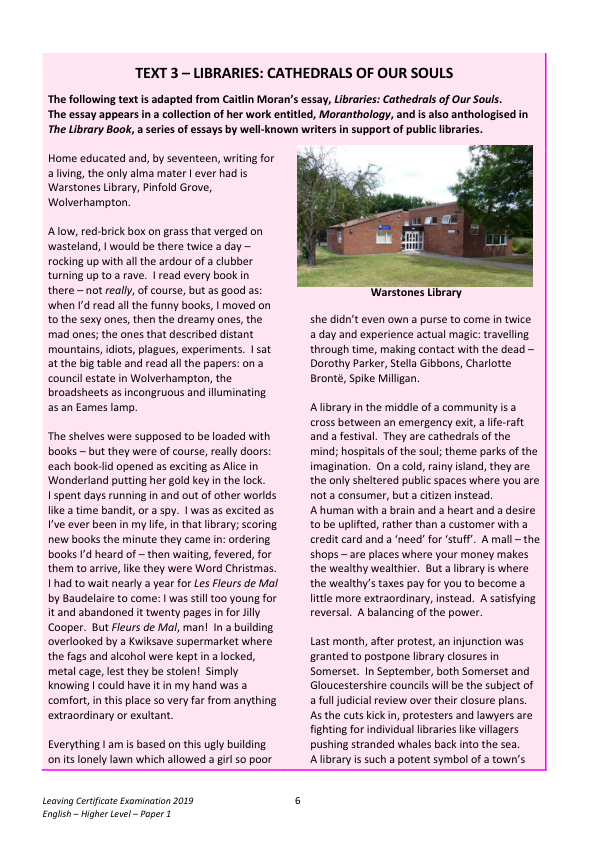

In [174]:
page = np.unique(df[df.caption2==1].page)[0]
page_df = df.loc[df.page==page, ["text", 'x0', 'y0', 'x1', 'y1', "page"]].copy()
doc_page = doc[int(page-1)]

pix = doc_page.get_pixmap(matrix=fitz.Matrix(1, 1))  # scale=2 for higher resolution
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
print(f"page: {page}")
display(img)

# Enrich doc_df with image information

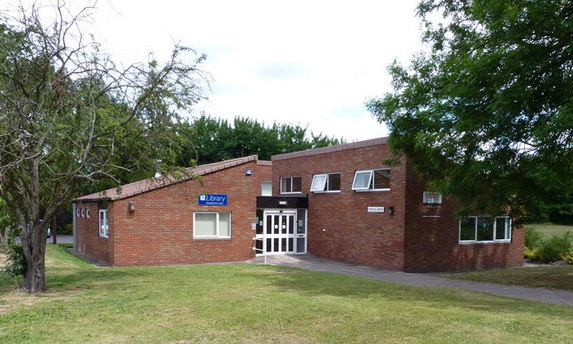

In [175]:
page_df     = df[df.page==page]
page_images = [image for image in images if image["page"]==page]
show_image(page_images[0])

In [176]:
page_df = enrich_doc_df_with_images(page_df,page_images)
page_df["dL"] = page_df.y0.diff()
page_df[['x0', 'y0', 'x1', 'y1', 'mode_font',  'text', 'font_size', 'image', 'page', 'counts']].head(40)

,x0,y0,x1,y1,mode_font,text,font_size,image,page,counts
0,135.24,65.98,456.68,82.00,Calibri-Bold,TEXT 3 – LIBRARIES: CATHEDRALS OF OUR SOULS,16.02,0,6,0.00
1,47.94,94.50,510.43,106.50,Calibri-Bold,"The following text is adapted from Caitlin Moran’s essay, Libraries: Cathedrals of Our Souls.",12.00,0,6,0.00
2,47.94,109.14,530.83,121.14,Calibri-Bold,"The essay appears in a collection of her work entitled, Moranthology, and is also anthologised in",12.00,0,6,0.00
3,47.94,123.78,485.53,135.78,Calibri-Bold,"The Library Book, a series of essays by well‐known writers in support of public libraries.",12.00,0,6,0.00
4,297.72,145.62,532.50,286.62,NaN,NaN,NaN,1,6,NaN
5,47.94,153.12,277.09,165.12,Calibri,"Home educated and, by seventeen, writing for",12.00,0,6,0.00
6,47.94,167.76,250.21,179.76,Calibri,"a living, the only alma mater I ever had is",12.00,0,6,0.00
7,47.94,182.40,214.81,194.40,Calibri,"Warstones Library, Pinfold Grove,",12.00,0,6,0.00
8,47.94,197.04,133.57,209.04,Calibri,Wolverhampton.,12.00,0,6,0.00
9,47.94,226.32,265.51,238.32,Calibri,"A low, red‐brick box on grass that verged on",12.00,0,6,0.00


# Basic dbscan on X0 and Y0

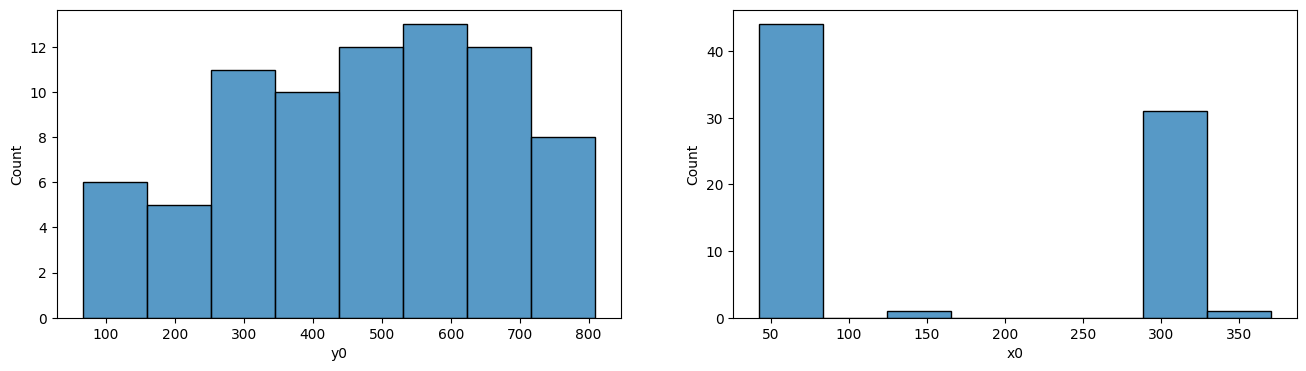

In [177]:
fig, axes = plt.subplots(1,2,figsize=(16,4))

sns.histplot(page_df.y0,ax=axes[0]);
sns.histplot(page_df.x0,ax=axes[1]);

## y0 scan

In [178]:
dL_y0 = find_y0_dL(page_df)
scan = DBSCAN(eps=dL_y0*1.15, min_samples=1)
scan.fit(page_df[["y0"]])
page_df["y_cluster"]=scan.labels_
page_df[['x0', 'y0', 'x1', 'y1', 'mode_font',  'text', 'font_size', 'image', 'page', 'counts',"y_cluster"]].head(5)


,x0,y0,x1,y1,mode_font,text,font_size,image,page,counts,y_cluster
0,135.24,65.98,456.68,82.00,Calibri-Bold,TEXT 3 – LIBRARIES: CATHEDRALS OF OUR SOULS,16.02,0,6,0.00,0
1,47.94,94.50,510.43,106.50,Calibri-Bold,"The following text is adapted from Caitlin Moran’s essay, Libraries: Cathedrals of Our Souls.",12.00,0,6,0.00,1
2,47.94,109.14,530.83,121.14,Calibri-Bold,"The essay appears in a collection of her work entitled, Moranthology, and is also anthologised in",12.00,0,6,0.00,1
3,47.94,123.78,485.53,135.78,Calibri-Bold,"The Library Book, a series of essays by well‐known writers in support of public libraries.",12.00,0,6,0.00,1
4,297.72,145.62,532.50,286.62,NaN,NaN,NaN,1,6,NaN,2


In [179]:
# get cluster bboxes
def get_cluster_boxes(df, labels):
    rectangies = []
    clust_labes = np.unique(labels)[1:] if -1 in labels else np.unique(labels)
    for i in clust_labes:
        temp_df = df[df.cluster==i]
        rectangies.append( Rect(get_df_bbox(temp_df)) )
    return rectangies

def get_category_boxes(df, cat):
    rectangies = []
    clust_labes = np.unique(df[cat])[1:] if -1 in df[cat] else np.unique(df[cat])
    for i in clust_labes:
        temp_df = df[df[cat]==i]
        rectangies.append( Rect(get_df_bbox(temp_df)) )
    return rectangies
rectangies = get_category_boxes(page_df, 'y_cluster')

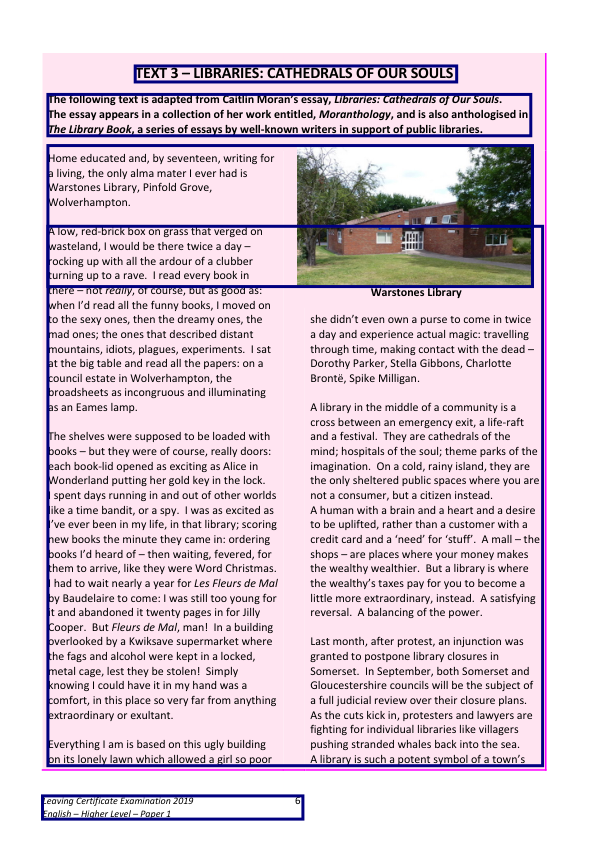

In [180]:
def get_bbox_page_image(doc,  page_number: int, rects: list[Rect], color: tuple[float]=(0,0,0.0) ) -> Image:
    i_p  = int(page_number-1)

    out_doc = fitz.open()
    out_doc.insert_pdf(doc, from_page=i_p, to_page=i_p)
    page = out_doc[0]

    for rect in rects:
        page.draw_rect(rect, color=color, width=3)
    pix = page.get_pixmap(matrix=fitz.Matrix(1, 1))  # scale=2 for higher resolution
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    out_doc.close()

    return img
y_img = get_bbox_page_image(doc, 6, rectangies,color=(0,0,0.5))
display(y_img)

- Because the closeness is only measured with y0, we can see that cluster 2 contains the image, and the lines down to wolverhampton 
- The bbox extracted from this goes to the end of the image, but actually only contains the images and the first paragraph.

## X0 scan

In [181]:
page_df[["x0","w"]]
median_w = page_df.w.dropna().map(round).median()

scan = DBSCAN(eps=0.5*median_w, min_samples=1)
scan.fit(page_df[["x0"]])
page_df["x_cluster"]=scan.labels_
page_df[['x0', 'y0', 'w', 'mode_font',  'text', 'font_size', 'image', 'counts',"y_cluster","x_cluster"]].head(5)
scan.labels_

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0])

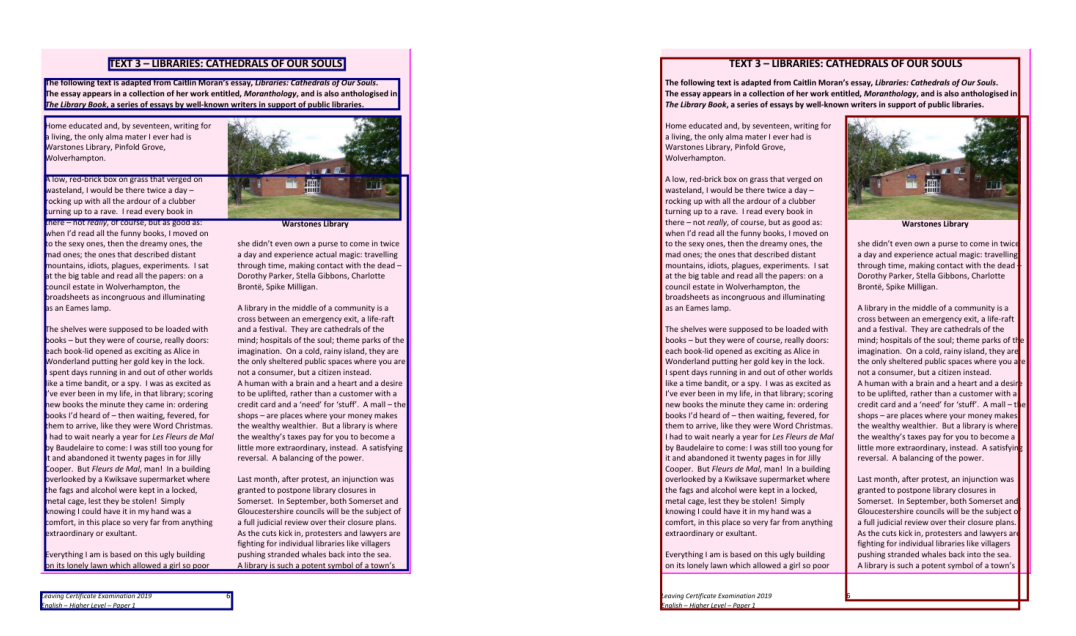

In [182]:
rectangies = get_category_boxes(page_df, 'x_cluster')
x_img = get_bbox_page_image(doc, 6, rectangies,color=(0.5,0,0.0))
fig, axes = plt.subplots(1,2,figsize=(16,8))

axes[0].imshow(y_img); axes[0].axis("off");
axes[1].imshow(x_img); axes[1].axis("off");
plt.subplots_adjust(wspace=0.0)


## Double scan

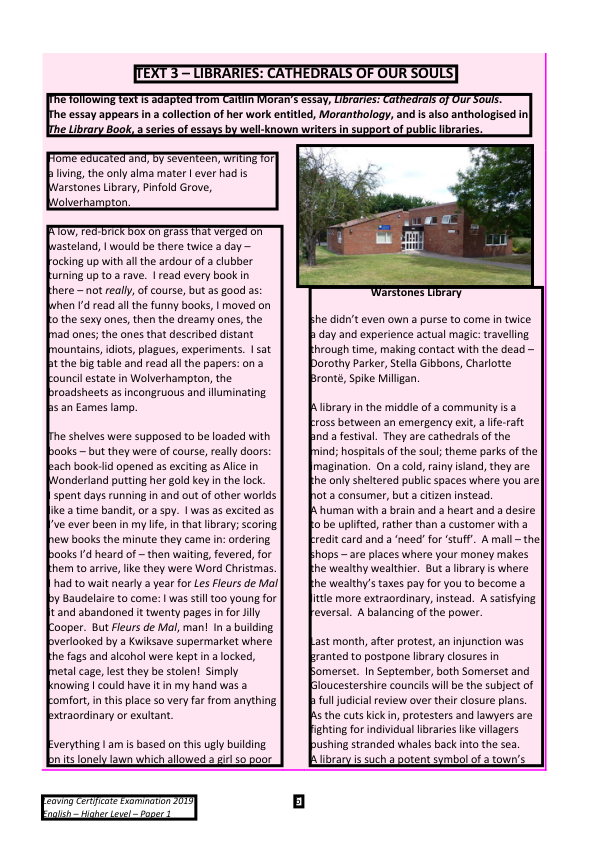

In [189]:
page_df["cluster_id"] = page_df.groupby(["x_cluster", "y_cluster"]).ngroup()
page_df[["cluster_id","x_cluster", "y_cluster"]]
page_df.cluster_id.value_counts()

rectangies = get_category_boxes(page_df, 'cluster_id')
xy_img = get_bbox_page_image(doc, 6, rectangies,color=(0.0,0,0.0))
display(xy_img)

- This is an improved clustering. But we notice that not all pagraphs are separated in y
  - Do another y clustering within each group.
  - The issue is that, when looking only at y, the existence of "A library in the middle" to the right of the paragraph ending in "Eames lamp" gives a false
    impression of contiguity.

# Scan using bbox distances